# LangGraph RAG Eval with RAGAS: Naive vs Semantic chunking

Lets setup API Keys:

In [1]:
import os
from getpass import getpass
os.environ["OPENAI_API_KEY"] = getpass("Please enter your OpenAI API key!")

Dataset generation using RAGAS

In [ ]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from ragas.testset import TestsetGenerator
import copy
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader) 
docs = loader.load()

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs[:20], testset_size=20)

dataset.to_pandas()



Applying HeadlinesExtractor:   0%|          | 0/17 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/20 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node


Applying SummaryExtractor:   0%|          | 0/29 [00:00<?, ?it/s]

Property 'summary' already exists in node '9c3d8f'. Skipping!
Property 'summary' already exists in node '5118bb'. Skipping!
Property 'summary' already exists in node '71a650'. Skipping!
Property 'summary' already exists in node 'd2a49e'. Skipping!
Property 'summary' already exists in node '83ea96'. Skipping!
Property 'summary' already exists in node '51038b'. Skipping!
Property 'summary' already exists in node '6ad28f'. Skipping!
Property 'summary' already exists in node 'b7882f'. Skipping!
Property 'summary' already exists in node 'bf33b9'. Skipping!
Property 'summary' already exists in node 'be161c'. Skipping!
Property 'summary' already exists in node 'c729fb'. Skipping!
Property 'summary' already exists in node 'b518e0'. Skipping!


Applying CustomNodeFilter:   0%|          | 0/10 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/43 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node '5118bb'. Skipping!
Property 'summary_embedding' already exists in node 'b518e0'. Skipping!
Property 'summary_embedding' already exists in node 'd2a49e'. Skipping!
Property 'summary_embedding' already exists in node '51038b'. Skipping!
Property 'summary_embedding' already exists in node '83ea96'. Skipping!
Property 'summary_embedding' already exists in node 'c729fb'. Skipping!
Property 'summary_embedding' already exists in node 'b7882f'. Skipping!
Property 'summary_embedding' already exists in node '71a650'. Skipping!
Property 'summary_embedding' already exists in node '9c3d8f'. Skipping!
Property 'summary_embedding' already exists in node 'bf33b9'. Skipping!
Property 'summary_embedding' already exists in node '6ad28f'. Skipping!
Property 'summary_embedding' already exists in node 'be161c'. Skipping!


Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/21 [00:00<?, ?it/s]

In [20]:
# For pandas DataFrames naive chunking
dataset_copy_naive = copy.deepcopy(dataset)
# For pandas DataFrames semantic chunking
dataset_copy_semantic = copy.deepcopy(dataset)

LangGraph\LangChain RAG. Definition of vector stores:

In [32]:

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader
import os, glob
from semantic_chunk_tool import extract_and_chunk_paragraphs
from langchain_core.documents import Document

path = "data/"

# Naive Chunking:
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
split_documents_naive = text_splitter.split_documents(docs)

# Semantic Chunking:
pdf_pattern = os.path.join(path, "*.pdf")
pdf_files = glob.glob(pdf_pattern)
    
if not pdf_files:
  print(f"No PDF files found in {path}")
    
split_documents_semantic =[]

for pdf_file in pdf_files:
    chunks = extract_and_chunk_paragraphs(pdf_file)
    split_documents_semantic.extend([Document(page_content=chunk) for chunk in chunks])

# define embeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# define qdrant client
client = QdrantClient(":memory:")

# define collections:
client.create_collection(
    collection_name="loan_data_naive",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)
client.create_collection(
    collection_name="loan_data_semantic",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# define vector stores:
vector_store_naive = QdrantVectorStore(
    client=client,
    collection_name="loan_data_naive",
    embedding=embeddings,
)
vector_store_semantic = QdrantVectorStore(
    client=client,
    collection_name="loan_data_semantic",
    embedding=embeddings,
)

# add documents to vector stores:
_ = vector_store_naive.add_documents(documents=split_documents_naive)
retriever_naive = vector_store_naive.as_retriever(search_kwargs={"k": 5})

_ = vector_store_semantic.add_documents(documents=split_documents_semantic)
retriever_semantic = vector_store_semantic.as_retriever(search_kwargs={"k": 5})

Definition of RAG graphs:

In [33]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

#Define common elements:

class State(TypedDict):
  question: str
  context: List[Document]
  response: str

# Define prompt:
RAG_PROMPT = """\
You are a helpful assistant who answers questions based on provided context. You must only use the provided context, and cannot use your own knowledge.

### Question
{question}

### Context
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

llm = ChatOpenAI(model="gpt-4.1-nano")

def generate(state):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
  response = llm.invoke(messages)
  return {"response" : response.content}

# Define retrieve functions:
def retrieve_naive(state):
  retrieved_docs = retriever_naive.invoke(state["question"])
  return {"context" : retrieved_docs}

def retrieve_semantic(state):
  retrieved_docs = retriever_semantic.invoke(state["question"])
  return {"context" : retrieved_docs}

# Define graph builder for naive chunking:
graph_builder_naive = StateGraph(State).add_sequence([retrieve_naive, generate])
graph_builder_naive.add_edge(START, "retrieve_naive")
graph_naive = graph_builder_naive.compile()

response_naive = graph_naive .invoke({"question" : "What are the different kinds of loans?"})

response_naive["response"]

# Define graph builder for naive chunking:
graph_builder_semantic = StateGraph(State).add_sequence([retrieve_semantic, generate])
graph_builder_semantic.add_edge(START, "retrieve_semantic")
graph_semantic = graph_builder_semantic.compile()

response_semantic = graph_semantic .invoke({"question" : "What are the different kinds of loans?"})

response_semantic["response"]

'The provided context discusses various types of loans related to the Direct Loan program, including specific conditions, eligibility, and disbursement rules. However, it does not explicitly list or describe different kinds of loans outside of the terms "Direct Subsidized Loans," "Direct Unsubsidized Loans," and "Direct PLUS Loans." \n\nBased on the information given, the different kinds of loans mentioned are:\n- Direct Subsidized Loans\n- Direct Unsubsidized Loans\n- Direct PLUS Loans (specifically for parents of dependent students)\n\n**Summary:**\n- **Direct Subsidized Loans**\n- **Direct Unsubsidized Loans**\n- **Direct PLUS Loans**\n\nThese are the main types of loans referenced in the context.'

Generate datasets (fill in the gaps) based on RAG answers:

In [34]:
# Naive Chunking dataset:
for test_row in dataset_copy_naive:
  response = graph_naive.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

dataset_copy_naive.samples[0].eval_sample.response

# Semantic Chunking dataset:
for test_row in dataset_copy_semantic:
  response = graph_semantic.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

dataset_copy_semantic.samples[0].eval_sample.response

"If a dependent undergraduate student's parents refuse to complete the FAFSA form, the student must be documented as having that situation. Under these circumstances, the student may be eligible for a dependent level Direct Unsubsidized Loan only, provided the institution documents that: \n\n- The student's parents refuse to complete the FAFSA; or \n- The student’s parents do not and will not provide any financial support to the student (including when support has ended).\n\nAdditionally, if the parents refuse to sign and date a statement to this effect, the institution must obtain documentation from a third party, such as a teacher, counselor, cleric, or court. \n\nThis situation does not automatically justify a dependency override. The institution has the discretion to resolve the situation, which may include requiring the student to submit a FAFSA and pass eligibility matches, leading to a rejected application if eligibility is not established. The student can then be awarded a Dire

RAGAS evaluation dataset definitions:

In [35]:
from ragas import EvaluationDataset
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluation_dataset_naive = EvaluationDataset.from_pandas(dataset_copy_naive.to_pandas())
evaluation_dataset_semantic = EvaluationDataset.from_pandas(dataset_copy_semantic.to_pandas())

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))

Desired metrics:

- Faithfulness  
- Answer Relevancy  
- Context Precision  
- Context Recall  
- Answer Correctness  

In [36]:
from ragas.metrics import Faithfulness, ResponseRelevancy, LLMContextPrecisionWithReference, LLMContextRecall, FactualCorrectness
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result_naive = evaluate( #type: ignore
    dataset=evaluation_dataset_naive,
    metrics=[Faithfulness(), ResponseRelevancy(), LLMContextPrecisionWithReference(), LLMContextRecall(), FactualCorrectness()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result_naive

result_semantic = evaluate( #type: ignore
    dataset=evaluation_dataset_semantic,
    metrics=[Faithfulness(), ResponseRelevancy(), LLMContextPrecisionWithReference(), LLMContextRecall(), FactualCorrectness()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result_semantic

Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

{'faithfulness': 0.9448, 'answer_relevancy': 0.9428, 'llm_context_precision_with_reference': 0.9177, 'context_recall': 0.9881, 'factual_correctness': 0.6443}

In [37]:
result_naive

{'faithfulness': 0.8813, 'answer_relevancy': 0.9446, 'llm_context_precision_with_reference': 0.9065, 'context_recall': 0.8810, 'factual_correctness': 0.5886}

In [38]:
result_semantic

{'faithfulness': 0.9448, 'answer_relevancy': 0.9428, 'llm_context_precision_with_reference': 0.9177, 'context_recall': 0.9881, 'factual_correctness': 0.6443}

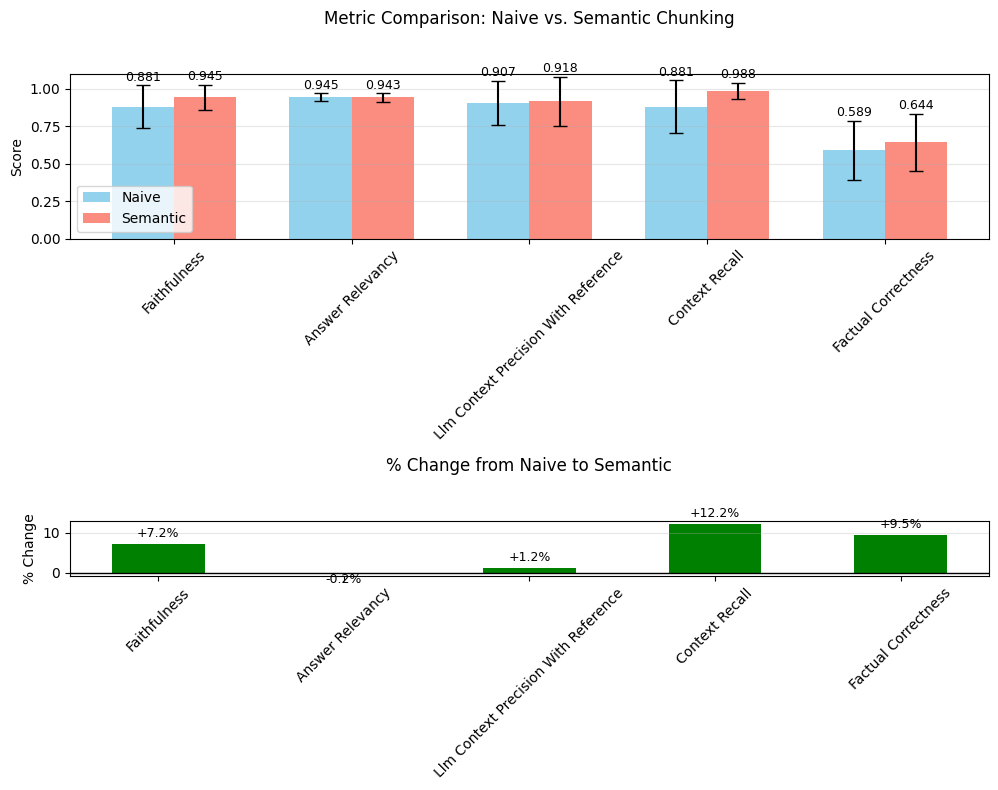

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert to DataFrames
df_naive = result_naive.to_pandas()
df_semantic = result_semantic.to_pandas()

# Compute means and standard deviations
naive_means = df_naive.mean(numeric_only=True)
naive_stds = df_naive.std(numeric_only=True)

semantic_means = df_semantic.mean(numeric_only=True)
semantic_stds = df_semantic.std(numeric_only=True)

# Extract metrics and values
metrics = list(naive_means.keys())
naive_scores = [naive_means[m] for m in metrics]
semantic_scores = [semantic_means[m] for m in metrics]
naive_err = [naive_stds[m] for m in metrics]
semantic_err = [semantic_stds[m] for m in metrics]
percent_change = [((s - n) / n) * 100 for s, n in zip(semantic_scores, naive_scores)]

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

x = np.arange(len(metrics))
width = 0.35

# Bar chart with error bars
bars1 = ax1.bar(x - width/2, naive_scores, width, yerr=naive_err, capsize=5, label='Naive', color='skyblue', alpha=0.9)
bars2 = ax1.bar(x + width/2, semantic_scores, width, yerr=semantic_err, capsize=5, label='Semantic', color='salmon', alpha=0.9)

ax1.set_ylabel('Score')
ax1.set_title('Metric Comparison: Naive vs. Semantic Chunking\n\n')
ax1.set_xticks(x)
ax1.set_xticklabels([m.replace('_', ' ').title() for m in metrics], rotation=45)
ax1.legend()
ax1.set_ylim(0, 1.1)
ax1.grid(True, axis='y', alpha=0.3)

# Add value labels above bars
for i in range(len(metrics)):
    ax1.text(x[i] - width/2, naive_scores[i] + naive_err[i] + 0.01, f'{naive_scores[i]:.3f}', ha='center', va='bottom', fontsize=9)
    ax1.text(x[i] + width/2, semantic_scores[i] + semantic_err[i] + 0.01, f'{semantic_scores[i]:.3f}', ha='center', va='bottom', fontsize=9)

# % change bar chart
colors = ['green' if p >= 0 else 'red' for p in percent_change]
ax2.bar(x, percent_change, width=0.5, color=colors)
ax2.axhline(0, color='black', linewidth=1)
ax2.set_ylabel('% Change')
ax2.set_xticks(x)
ax2.set_xticklabels([m.replace('_', ' ').title() for m in metrics], rotation=45)
ax2.set_title('% Change from Naive to Semantic\n\n')
ax2.grid(True, axis='y', alpha=0.3)

# Add % labels
for i, pct in enumerate(percent_change):
    ax2.text(x[i], pct + (1 if pct >= 0 else -3), f'{pct:+.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
